# Predicting selling price of houses
In this notebook, I will be using multiple datasets to predict the selling price of houses in Boston. Features are built from different datasets and are combined in the `../feature_engineering` directory. I will build the feature matrix progressively, starting from the most basic features. Then I will train the dataset using gradient boosting tree. Let's load the full feature dataframe.
 

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

property_type = 'townhouse'


df_features = pd.read_csv('../data/processed/' + 'Boston_%s_feature_matrix.csv'%property_type,index_col=0)
feature_names = df_features.columns
print(feature_names)


Index(['convenience', 'supermarket', 'park', 'school', 'station',
       'stop_position', 'LIST PRICE', 'SQUARE FEET', 'YEAR BUILT', 'BEDS',
       'BATHS', 'LOT SIZE', 'HOA/MONTH', 'EST $ TREND', 'REMARKS_1',
       'REMARKS_2', 'REMARKS_3', 'REMARKS_4', 'REMARKS_5', 'REMARKS_6',
       'REMARKS_7', 'REMARKS_8', 'REMARKS_9', 'REMARKS_10', 'SOLD PRICE',
       'SOLD DATE'],
      dtype='object')


First we use the real estate data: size, age, number of beds, baths, lot size and HOA/month to predict the selling price. The features are readily available from `../data/raw/redfin_2020-01-19-08-17-26.csv`, which is downloaded from `www.redfin.com`.

In [4]:
df_features.pop('LIST PRICE')

feature_real_estate = ['SQUARE FEET','YEAR BUILT','BEDS','BATHS','LOT SIZE','HOA/MONTH']

X = df_features[feature_real_estate].values
Y = df_features.pop('SOLD PRICE').values

N = len(X)
print('number of data: ',N)
Nfeature = len(feature_real_estate)
print('number of features: ',Nfeature)
train_size = int(0.7*N)

Xtrain = X[:train_size]
Xtest = X[train_size:]

Ytrain = Y[:train_size]
Ytest = Y[train_size:]

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)
print('Ytrain.shape: ',Ytrain.shape)
print('Ytest.shape: ',Ytest.shape)




number of data:  598
number of features:  6
Xtrain.shape:  (418, 6)
Xtest.shape:  (180, 6)
Ytrain.shape:  (418,)
Ytest.shape:  (180,)


In [5]:
params = {'max_depth':[6,7,8,9,10],'n_estimators':[10,20,30,40,50],
          'learning_rate':[0.01,0.1,1]}

cv_scores = []
cv_scores_std = []
models = []

regr_cv = GridSearchCV(GradientBoostingRegressor(),
                       params,
                       cv=5)

print('training')
regr_cv.fit(Xtrain,Ytrain)

best_param = regr_cv.best_params_

regr_score = GradientBoostingRegressor(max_depth=best_param['max_depth'],
                                   n_estimators=best_param['n_estimators'])

cv_score = cross_val_score(regr_cv, Xtrain, Ytrain, cv=5)
print('regr score: %.3f +/- %.5f'%(np.mean(cv_score),np.std(cv_score)))
print('best param: ',regr_cv.best_params_)

cv_scores.append(np.mean(cv_score))
cv_scores_std.append(np.std(cv_score))
models.append(regr_cv)


training
regr score: 0.264 +/- 0.06549
best param:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 20}


The property price not only depends on the property itself but also the surronding amenities. Next we will include the geospatial data: e.g. how many convenience stores are there within 500m radius of a property? I gathered the data from an online query system called Overpass turbo and save the data in `.json`. The implementation can be found in `../feature_engineering/GetPOI.py`.

In [6]:
feature_geospatial = ['convenience','supermarket','park','school','station','stop_position']

feature_total = feature_real_estate + feature_geospatial
X = df_features[feature_total].values


N = len(X)
print('number of data: ',N)
Nfeature = len(feature_total)
print('number of features: ',Nfeature)
train_size = int(0.7*N)

Xtrain = X[:train_size]
Xtest = X[train_size:]

Ytrain = Y[:train_size]
Ytest = Y[train_size:]

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)
print('Ytrain.shape: ',Ytrain.shape)
print('Ytest.shape: ',Ytest.shape)

number of data:  598
number of features:  12
Xtrain.shape:  (418, 12)
Xtest.shape:  (180, 12)
Ytrain.shape:  (418,)
Ytest.shape:  (180,)


In [7]:
regr_cv = GridSearchCV(GradientBoostingRegressor(),
                       params,
                       cv=5)

print('training')
regr_cv.fit(Xtrain,Ytrain)

best_param = regr_cv.best_params_

regr_score = GradientBoostingRegressor(max_depth=best_param['max_depth'],
                                   n_estimators=best_param['n_estimators'])

cv_score = cross_val_score(regr_cv, Xtrain, Ytrain, cv=5)
print('regr score: %.3f +/- %.5f'%(np.mean(cv_score),np.std(cv_score)))
print('best param: ',regr_cv.best_params_)

cv_scores.append(np.mean(cv_score))
cv_scores_std.append(np.std(cv_score))
models.append(regr_cv)

training
regr score: 0.533 +/- 0.10996
best param:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 30}


So far I have left out information about the interior of the property, e.g. is the basement/kitchen renovated? To incorporate this information, I will now include features derived from the broker's remarks. I first extracted ten topics using non-negative matrix factorization (NMF). Then I calculated, for each home, the similarity between each topic and the remark and thus generate a 10-dimensional feature for each house. The implementation can be found in `../feature_engineering/GetTopicVector.py`.

In [8]:
feature_remarks = ['REMARKS_%i'%(i+1) for i in range(10)]

feature_total = feature_real_estate + feature_geospatial + feature_remarks
X = df_features[feature_total].values


N = len(X)
print('number of data: ',N)
Nfeature = len(feature_total)
print('number of features: ',Nfeature)
train_size = int(0.7*N)

Xtrain = X[:train_size]
Xtest = X[train_size:]

Ytrain = Y[:train_size]
Ytest = Y[train_size:]

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)
print('Ytrain.shape: ',Ytrain.shape)
print('Ytest.shape: ',Ytest.shape)

number of data:  598
number of features:  22
Xtrain.shape:  (418, 22)
Xtest.shape:  (180, 22)
Ytrain.shape:  (418,)
Ytest.shape:  (180,)


In [9]:
regr_cv = GridSearchCV(GradientBoostingRegressor(),
                       params,
                       cv=5)

print('training')
regr_cv.fit(Xtrain,Ytrain)

best_param = regr_cv.best_params_

regr_score = GradientBoostingRegressor(max_depth=best_param['max_depth'],
                                   n_estimators=best_param['n_estimators'])

cv_score = cross_val_score(regr_cv, Xtrain, Ytrain, cv=5)
print('regr score: %.3f +/- %.5f'%(np.mean(cv_score),np.std(cv_score)))
print('best param: ',regr_cv.best_params_)

cv_scores.append(np.mean(cv_score))
cv_scores_std.append(np.std(cv_score))
models.append(regr_cv)

training
regr score: 0.571 +/- 0.12059
best param:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 40}


As mentioned in `eda.ipynb`, the housing market trend is also a big factor in determining the selling price. For simplicity, I use the average price/sqft of properties sold in the last day as a proxy of the market trend. More sophisticated model such as LSTM can also be used to get a potentially more accurate prediction of the price/sqft trend. I have done some EDA on the price trend in `./lstm_eda.ipynb` to explore the feasibility of using LSTM to get a better estimation of the price trend.

In [10]:
feature_trend = ['EST $ TREND']

feature_total = feature_real_estate + feature_geospatial + feature_remarks + feature_trend
X = df_features[feature_total].values


N = len(X)
print('number of data: ',N)
Nfeature = len(feature_total)
print('number of features: ',Nfeature)
train_size = int(0.7*N)

Xtrain = X[:train_size]
Xtest = X[train_size:]

Ytrain = Y[:train_size]
Ytest = Y[train_size:]

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)
print('Ytrain.shape: ',Ytrain.shape)
print('Ytest.shape: ',Ytest.shape)

number of data:  598
number of features:  23
Xtrain.shape:  (418, 23)
Xtest.shape:  (180, 23)
Ytrain.shape:  (418,)
Ytest.shape:  (180,)


In [11]:
regr_cv = GridSearchCV(GradientBoostingRegressor(),
                       params,
                       cv=5)

print('training')
regr_cv.fit(Xtrain,Ytrain)

best_param = regr_cv.best_params_

regr_score = GradientBoostingRegressor(max_depth=best_param['max_depth'],
                                   n_estimators=best_param['n_estimators'])

cv_score = cross_val_score(regr_cv, Xtrain, Ytrain, cv=5)
print('regr score: %.3f +/- %.5f'%(np.mean(cv_score),np.std(cv_score)))
print('best param: ',regr_cv.best_params_)

cv_scores.append(np.mean(cv_score))
cv_scores_std.append(np.std(cv_score))
models.append(regr_cv)

training
regr score: 0.557 +/- 0.10248
best param:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}


Finally, let's take a look at the improvements in the cross validation r2 scores due to the additions of each dataset

<IPython.core.display.Javascript object>


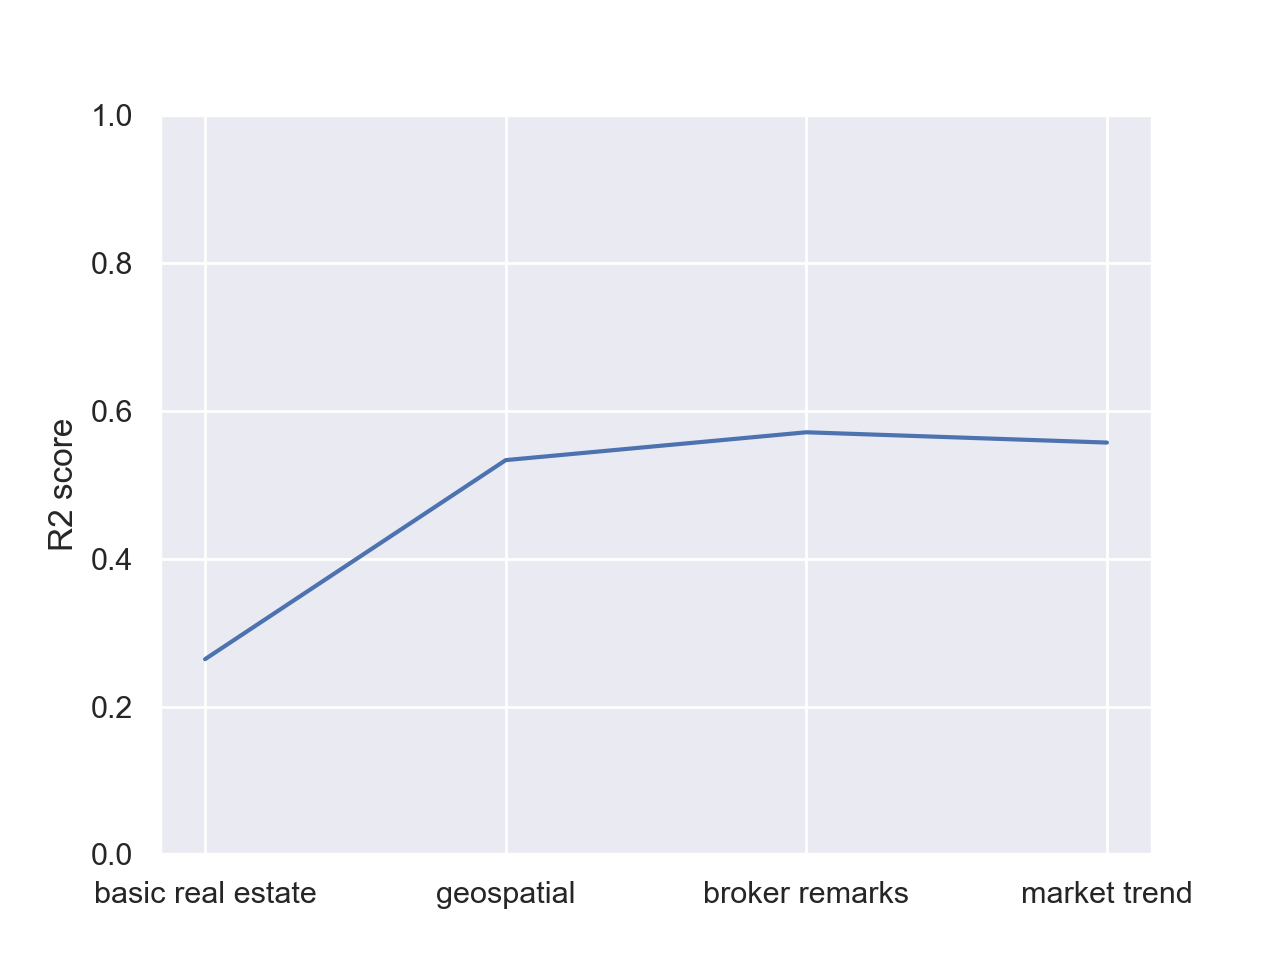

In [26]:
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns

sns.set()

fig = plt.figure()
plt.plot(list(range(len(cv_scores))),cv_scores)
plt.ylim([0,1])
plt.xticks(list(range(len(cv_scores))),['basic real estate','geospatial','broker remarks','market trend'])
plt.ylabel('R2 score')
plt.show()

# Testing performance

<IPython.core.display.Javascript object>


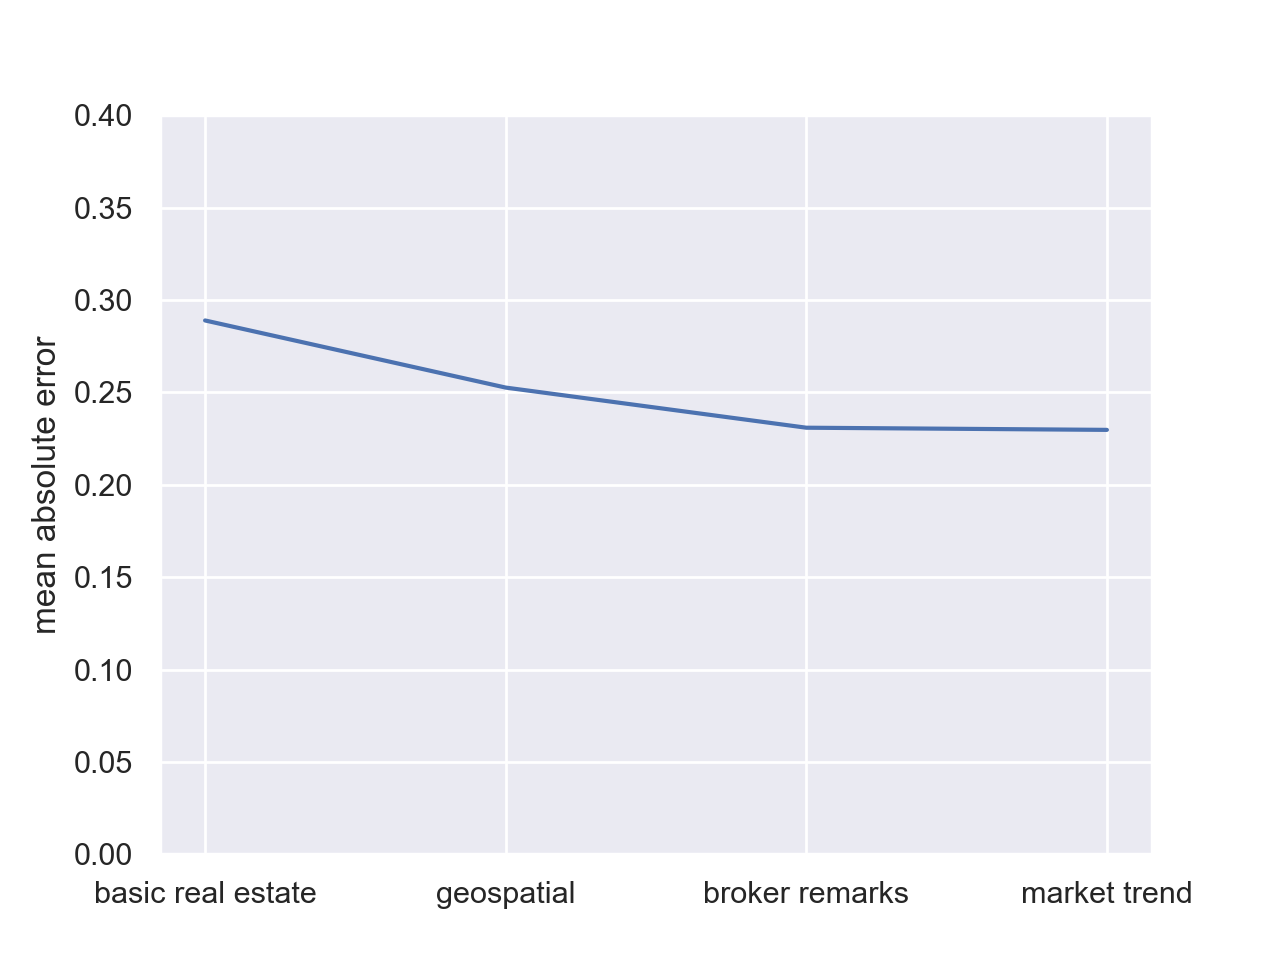

In [27]:
#feature_total = feature_real_estate + feature_geospatial + feature_remarks + feature_trend

MAEs = []

feature_total = feature_real_estate
X = df_features[feature_total].values

train_size = int(0.7*len(X))
Xtest = X[train_size:]
Ytest = Y[train_size:]

Ypredict = models[0].predict(Xtest)
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))

feature_total = feature_real_estate + feature_geospatial
X = df_features[feature_total].values

train_size = int(0.7*len(X))
Xtest = X[train_size:]
Ytest = Y[train_size:]

Ypredict = models[1].predict(Xtest)
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))

feature_total = feature_real_estate + feature_geospatial + feature_remarks
X = df_features[feature_total].values

train_size = int(0.7*len(X))
Xtest = X[train_size:]
Ytest = Y[train_size:]

Ypredict = models[2].predict(Xtest)
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))

feature_total = feature_real_estate + feature_geospatial + feature_remarks + feature_trend
X = df_features[feature_total].values

train_size = int(0.7*len(X))
Xtest = X[train_size:]
Ytest = Y[train_size:]

Ypredict = models[3].predict(Xtest)
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))



fig = plt.figure()
plt.plot(list(range(len(MAEs))),MAEs)
plt.ylim([0,0.4])
plt.xticks(list(range(len(MAEs))),['basic real estate','geospatial','broker remarks','market trend'])
plt.ylabel('mean absolute error')
plt.show()